# Song of Bengalese finches

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import librosa.feature
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorcet as cc
import matplotlib
import deepss_unsupervised.spec_utils
import umap
import hdbscan
from io import BytesIO
import urllib.request

plt.style.use('ncb.mplstyle')

/Users/janc/miniconda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/janc/miniconda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', please update to use 'numba.core

In [2]:
# data from: D Nicholson, JE Queen, S Sober (2017). Bengalese finch song repository. https://doi.org/10.6084/m9.figshare.4805749.v5
url = 'https://github.com/janclemenslab/deepss_unsupervised/releases/download/v0.4/birds.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
recording = d['recording']
syllable_onsets = d['syllable_onsets']
syllable_offsets = d['syllable_offsets']
syllable_types = d['syllable_types']
samplerate = d['samplerate']


In [3]:
import noisereduce as nr
noise_clip = recording[:150_000]
x_nr = nr.reduce_noise(audio_clip=recording, noise_clip=noise_clip, verbose=False)

(128,)


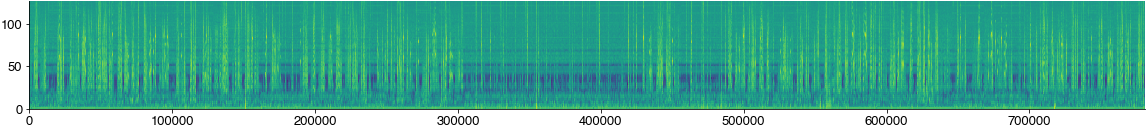

In [4]:

hop_length = int(2 * samplerate / 1000)
win_length = int(10 * samplerate / 1000 * 2)
specgram = librosa.feature.melspectrogram(x_nr, sr=samplerate, n_fft=win_length, hop_length=hop_length, power=2)
specgram = specgram[np.where(specgram[:,0]!=0)[0],:]
sm = np.median(specgram, axis=1)
print(sm.shape)
plt.figure(figsize=(20, 2))
plt.imshow(np.log2(specgram))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

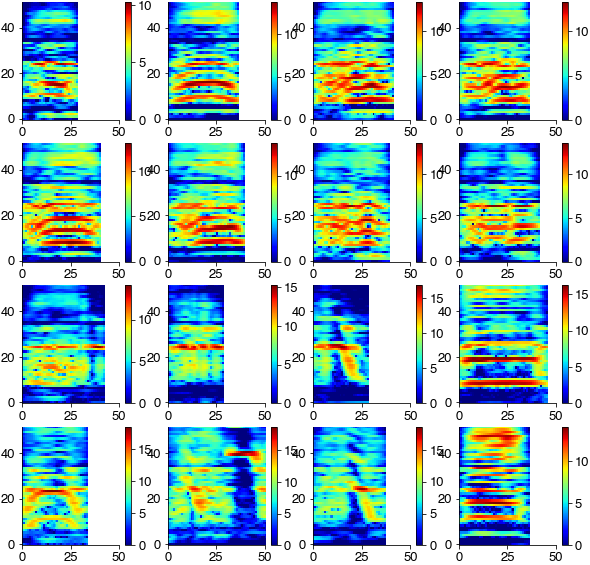

In [5]:
specs = [] 

plt.figure(figsize=(10, 10))
for cnt, (onset, offset) in enumerate(zip(syllable_onsets, syllable_offsets)):
    spec = np.log2(specgram[:, int(onset/hop_length):int(offset/hop_length)] / sm[:, np.newaxis])
    spec = spec[4:-20:2, :]
    spec = spec - 2
    spec[spec<0] = 0
    specs.append(spec)
    try:
        plt.subplot(4,4,cnt+1)
        plt.imshow(specs[-1], cmap='jet')
        plt.xlim(0, 50)
        plt.colorbar()
    except:
        pass
plt.show

In [6]:
spec_rs = [deepss_unsupervised.spec_utils.log_resize_spec(spec, scaling_factor=8) for spec in specs]

max_len = np.max([spec.shape[1] for spec in spec_rs])
spec_rs = [deepss_unsupervised.spec_utils.pad_spec(spec, pad_length=max_len) for spec in spec_rs]

In [7]:
spec_flat = [spec.ravel() for spec in spec_rs]
spec_flat = np.array(spec_flat)

In [8]:
out = umap.UMAP(min_dist=0.5).fit_transform(spec_flat)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20).fit_predict(out)

/Users/janc/miniconda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


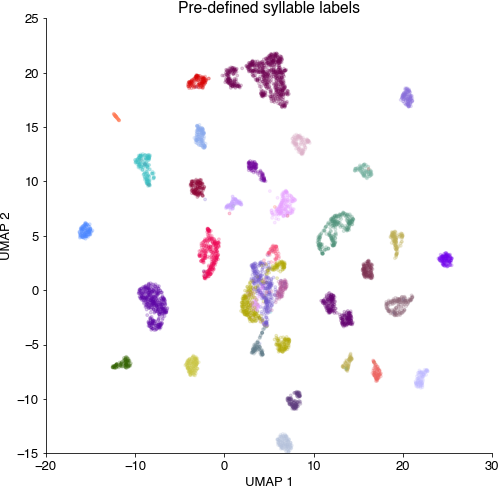

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(out[:,0], out[:,1], c=syllable_types, cmap='cet_glasbey_dark', alpha=0.2, s=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Pre-defined syllable labels')
plt.show()

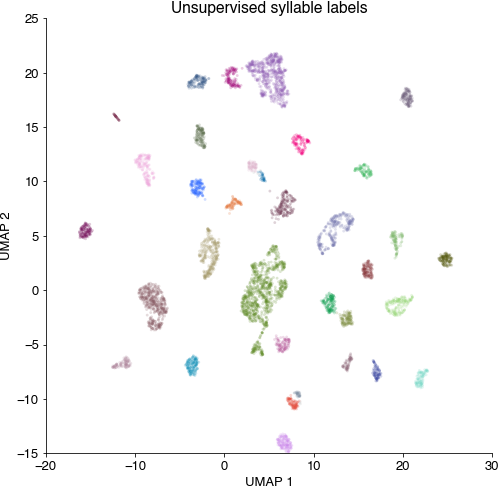

In [10]:
plt.figure(figsize=(8, 8))
cmap = cc.palette['glasbey_dark']
cmap = list(cmap)
cmap.insert(0, (0.7, 0.7, 0.7))
cmap = ListedColormap(cmap)
plt.scatter(out[:,0], out[:,1], c=hdbscan_labels, cmap=cmap, alpha=0.2, s=8, edgecolor='none')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Unsupervised syllable labels')
plt.show()

Homogeneity_score: 0.91
 Completeness_score: 0.93
 V_measure_score: 0.92


/Users/janc/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


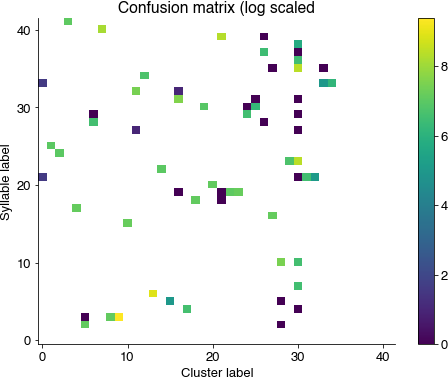

In [11]:
C = sklearn.metrics.confusion_matrix(syllable_types, hdbscan_labels)
plt.figure(figsize=(8, 6))
plt.imshow(np.log2(C))
plt.colorbar()
plt.title('Confusion matrix (log scaled')
plt.ylabel('Syllable label')
plt.xlabel('Cluster label')

print(f'Homogeneity_score: {sklearn.metrics.homogeneity_score(syllable_types, hdbscan_labels):1.2f}\n',
      f'Completeness_score: {sklearn.metrics.completeness_score(syllable_types, hdbscan_labels):1.2f}\n',
      f'V_measure_score: {sklearn.metrics.v_measure_score(syllable_types, hdbscan_labels):1.2f}')

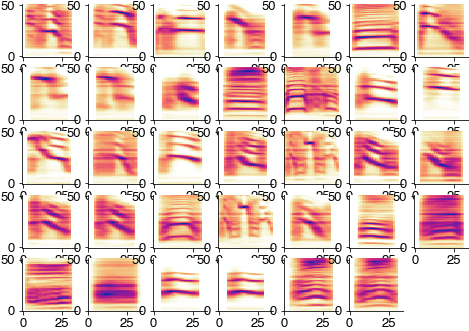

In [12]:
  plt.figure(figsize=(8, 8))
  for label in np.unique(hdbscan_labels):
      if label>=0:
        idx = np.where(hdbscan_labels==label)[0]
        plt.subplot(7, 7, label+1)
        plt.imshow(np.mean(np.array(spec_rs)[idx], axis=0), cmap='cet_CET_L17')
